In [1]:
import os
import random
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.metrics import Precision, Recall

import keras_tuner as kt
from keras.optimizers import Adam

In [2]:
top_dir = '/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset'

# Define the training paths
train_dir = os.path.join(top_dir, 'train')

# List all directories in the train directory
all_directories = os.listdir(train_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
train_human = []
train_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        train_human.append(os.path.join(train_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        train_ai.append(os.path.join(train_dir, directory))

# Print the lists of directories
print("Train directories containing human-drawn images:")
for i, directory in enumerate(train_human):
    print(f"{i}. {directory}")

print("\nTrain directories containing AI-generated images:")
for i, directory in enumerate(train_ai):
    print(f"{i}. {directory}")

Train directories containing human-drawn images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/renaissance
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/surrealism
3. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/art_nouveau
4. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/baroque
5. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/expressionism
6. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/romanticism
7. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e
8. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/post_impressionism
9. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/realism

Train directories containing AI-generated images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_SD_impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_LD_post_impressionism
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/tr

In [3]:
# Define the test paths
test_dir = os.path.join(top_dir, 'test')

# List all directories in the test directory
all_directories = os.listdir(test_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
test_human = []
test_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        test_human.append(os.path.join(test_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        test_ai.append(os.path.join(test_dir, directory))

# Print the lists of directories
print("Test directories containing human-drawn images:")
for i, directory in enumerate(test_human):
    print(f"{i}. {directory}")

print("\nTest directories containing AI-generated images:")
for i, directory in enumerate(test_ai):
    print(f"{i}. {directory}")

Test directories containing human-drawn images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/renaissance
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/surrealism
3. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/art_nouveau
4. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/baroque
5. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/expressionism
6. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/romanticism
7. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/ukiyo_e
8. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/post_impressionism
9. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/realism

Test directories containing AI-generated images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_SD_impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_LD_post_impressionism
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_LD_art_n

In [4]:
# Plot k-number of images from the dataset
def plot_im(directory, k):
    files = os.listdir(directory)
    im = random.choices(files, k=k)

    fig = plt.figure()

    for i in range(k):
        im_i_path = os.path.join(directory, im[i])  # File path
        im_i = cv2.imread(im_i_path)
        
        # Add subplot
        ax = fig.add_subplot(int(np.sqrt(k)), int(np.sqrt(k)), i + 1)
        
        # Plot image
        ax.imshow(im_i)
        ax.axis('off')
        
        # Display filename below the image
        ax.set_title(im[i], fontsize=8, pad=2)

    plt.tight_layout()  # Adjust layout
    plt.show()

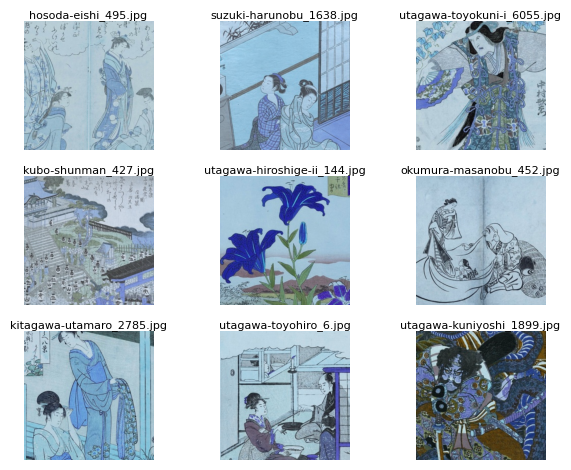

In [5]:
# Visualize random images from train_human. Catagory is sorted in order of output in cell 2
real_im = plot_im(directory=train_human[7], k=9)  
plt.show()

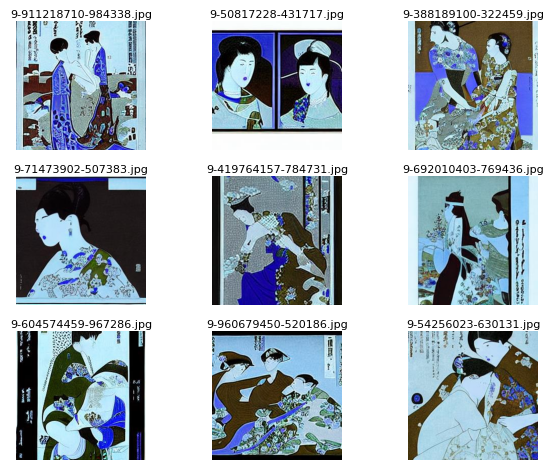

In [6]:
# Visualize random images from train_ai. Catagory is sorted in order of output in cell 2
ai_im = plot_im(directory=train_ai[4], k=9)  
plt.show()

In [7]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for train_data
train_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under train_human as "human"
for directory in train_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under train_ai as "AI"
for directory in train_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with train_data
train_data = pd.concat([train_data, data], ignore_index=True)

In [8]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human


In [9]:
# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("Number of files under each label:")
print(file_counts)

Number of files under each label:
label
AI       105015
human     50000
Name: count, dtype: int64


In [10]:
# Set the random seed for reproducibility
random_seed = 123  # Change this to your desired seed number
np.random.seed(random_seed)

# Number of rows to drop for the 'AI' label
num_to_drop = 55015

# Get the indices of rows with the 'AI' label
ai_indices = train_data[train_data['label'] == 'AI'].index

# Randomly select indices to drop using the specified seed
indices_to_drop = np.random.choice(ai_indices, num_to_drop, replace=False)

# Drop the selected rows from the DataFrame
train_data = train_data.drop(indices_to_drop)

# Reset the index of the DataFrame after dropping rows
train_data.reset_index(drop=True, inplace=True)

In [11]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human

Number of files under each label:
label
human    50000
AI       50000
Name: count, dtype: int64


In [12]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for test_data
test_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under test_human as "human"
for directory in test_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under test_ai as "AI"
for directory in test_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with test_data
test_data = pd.concat([test_data, data], ignore_index=True)

In [13]:
# Display the first few rows of the test_data DataFrame
print(test_data.head())

# Count the number of files under each label
file_counts = test_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human

Number of files under each label:
label
AI       20000
human    10000
Name: count, dtype: int64


In [14]:
target_size = (128, 128) 
batch_size = 64
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.05,
    brightness_range=[0.9, 1.1]
)

# 🔹 Chargement du dataset d'entraînement
train_dataset = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # 🔹 Vérifier si multi-classes
    shuffle=True
)

Found 100000 validated image filenames belonging to 2 classes.


In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_dataset = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
test_dataset.class_indices

Found 30000 validated image filenames belonging to 2 classes.


{'AI': 0, 'human': 1}

In [16]:
test_dataset.class_indices

{'AI': 0, 'human': 1}

In [17]:
# Vision Transformer (ViT) Parameters
image_size = 128
patch_size = 16
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 2
mlp_head_units = [512, 256]

In [18]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

In [19]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        return self.projection(patch) + self.position_embedding(positions)

In [20]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [21]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)

In [22]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def build_vit_hybrid_model(input_shape=(128, 128, 3), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    
    # ✅ Data Augmentation
    augmented = data_augmentation(inputs)

    # ✅ Patch Encoding for ViT
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # ✅ Transformer Blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    # ✅ ViT Feature Extraction
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # ✅ CNN Feature Extraction (Plus Profond)
    cnn_block = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    cnn_block = layers.BatchNormalization()(cnn_block)
    cnn_block = layers.MaxPooling2D((2, 2))(cnn_block)
    
    cnn_block = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(cnn_block)
    cnn_block = layers.BatchNormalization()(cnn_block)
    cnn_block = layers.MaxPooling2D((2, 2))(cnn_block)
    
    cnn_block = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(cnn_block)
    cnn_block = layers.BatchNormalization()(cnn_block)
    cnn_block = layers.MaxPooling2D((2, 2))(cnn_block)
    
    cnn_block = layers.Flatten()(cnn_block)
    cnn_block = layers.Dropout(0.5)(cnn_block)

    # ✅ Fusion ViT + CNN
    fusion = layers.Concatenate()([representation, cnn_block])
    fusion = layers.Dense(256, activation='relu')(fusion)  # Ajout d'une Dense après fusion
    fusion = layers.Dropout(0.5)(fusion)

    # ✅ Final Classification
    outputs = layers.Dense(num_classes, activation='softmax')(fusion)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [23]:
vit_hybrid_model = build_vit_hybrid_model(input_shape=(image_size, image_size, 3), num_classes=2)

vit_hybrid_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = vit_hybrid_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
) 

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1502s 949ms/step - Precision: 0.8057 - Recall: 0.8057 - accuracy: 0.8057 - loss: 0.9890 - val_Precision: 0.7890 - val_Recall: 0.7890 - val_accuracy: 0.7890 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 832s 530ms/step - Precision: 0.8886 - Recall: 0.8886 - accuracy: 0.8886 - loss: 0.2751 - val_Precision: 0.7848 - val_Recall: 0.7848 - val_accuracy: 0.7848 - val_loss: 0.8922 - learning_rate: 0.0010
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 825s 526ms/step - Precision: 0.9104 - Recall: 0.9104 - accuracy: 0.9104 - loss: 0.2293 - val_Precision: 0.8600 - val_Recall: 0.8600 - val_accuracy: 0.8600 - val_loss: 0.4680 - learning_rate: 0.0010
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 837s 534ms/step - Precision: 0.9236 - Recall: 0.9236 - accuracy: 0.9236 - loss: 0.2005 - val_Precision: 0.8017 - val_Recall: 0.8017 - val_accuracy: 0.8017 - val_loss: 1.0154 - learning_rate: 0.0010
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 827s 528

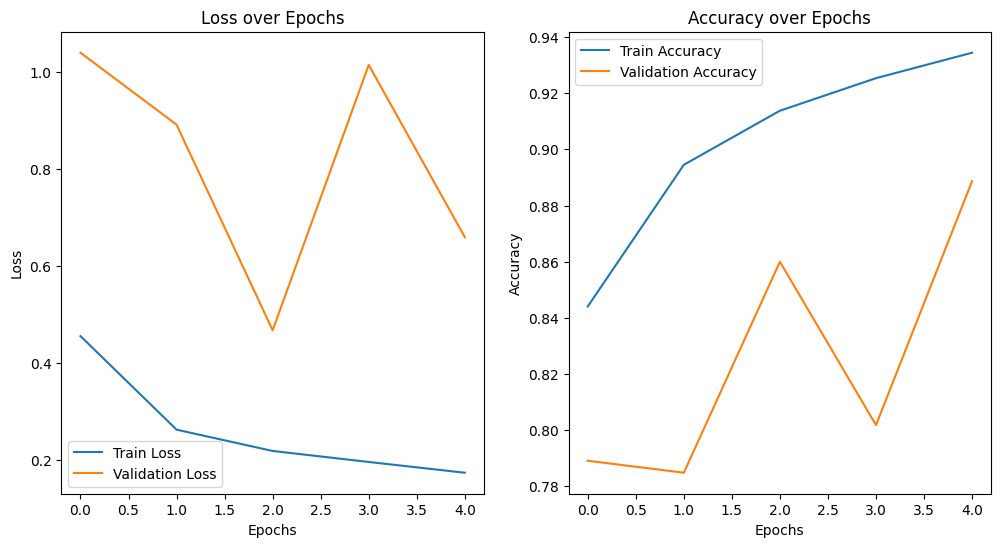

In [26]:
# Affichage des courbes de perte et de précision
def plot_metrics(history):
    # Affichage de la courbe de perte
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Affichage de la courbe de précision
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Appel de la fonction pour afficher les courbes
plot_metrics(history) 

In [28]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🎯 Prédictions
y_pred_probs = vit_hybrid_model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Extraire les vraies classes (fonctionne seulement si test_dataset est une ImageDataGenerator/flow_from_directory)
y_true = test_dataset.classes  

# ✅ Obtenir les noms de classes
class_names = list(test_dataset.class_indices.keys())

# 📋 Rapport de classification
print("📊 Rapport de classification :")
print(classification_report(y_true, y_pred, target_names=class_names))


30000/30000 ━━━━━━━━━━━━━━━━━━━━ 121s 4ms/step
📊 Rapport de classification :
              precision    recall  f1-score   support

          AI       0.92      0.86      0.89     20000
       human       0.75      0.86      0.80     10000

    accuracy                           0.86     30000
   macro avg       0.84      0.86      0.85     30000
weighted avg       0.87      0.86      0.86     30000



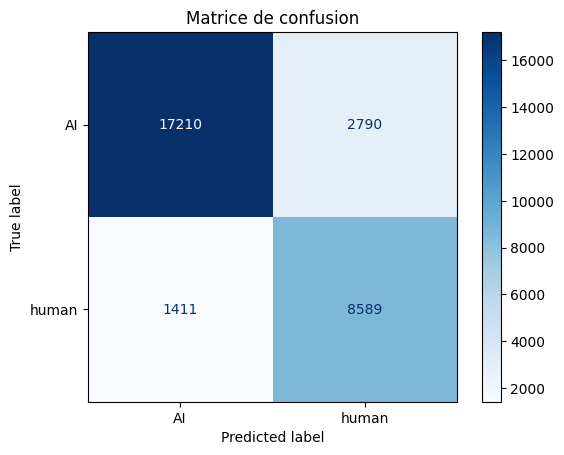

In [29]:

# 📉 Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Matrice de confusion")
plt.show()


In [30]:
# 📦 Sauvegarde du modèle (structure)
vit_hybrid_model_json = vit_hybrid_model.to_json()
with open("vit_hybrid_model.json", "w") as json_file:
    json_file.write(vit_hybrid_model_json)



In [31]:
# 💾 Sauvegarde des poids uniquement
vit_hybrid_model.save_weights("vit_hybrid_.weights.h5")